In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
import csv
import io
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from pywaffle import Waffle

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [2]:
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.collocations import *
try:
    stopwords = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
#stopwords

In [3]:
#pour Adrien
def creation_csv(nom_livre,numero_livre):
    chemin = r"C:\Users\adxva\OneDrive\Bureau\ENSAE 2A - S1\Harry-Python\Data\Books txt\Book " + numero_livre + " - "  + nom_livre + ".txt"
    sortie = r"C:\Users\adxva\OneDrive\Bureau\ENSAE 2A - S1\Harry-Python\Data\Books CSV\Book " + numero_livre + ".csv"
    with io.open(chemin,"r",encoding="utf-8") as infile, open(sortie, 'w',encoding = 'utf-8-sig') as outfile:
        stripped = (line.strip() for line in infile)
        lines = (line.split(",") for line in stripped if line)
        writer = csv.writer(outfile)
        writer.writerows(lines)

In [4]:
#On crée un dictionnaire
Books = {'The Philosophers Stone': '1',
        'The Chamber of Secrets': '2',
        'The Prisoner of Azkaban': '3',
        'The Goblet of Fire':'4',
        'The Order of the Phoenix': '5',
        'The Half Blood Prince': '6',
        'The Deathly Hallows': '7'}

In [5]:
#Pour Adrien
#On fait une boucle exécutant la fonction sur chaque élément du dictionnaire
Books_csv = {}
for title, i in Books.items():
    creation_csv(title, i)
    Books_csv['book' + i] = pd.read_csv(r"C:\Users\adxva\OneDrive\Bureau\ENSAE 2A - S1\Harry-Python\Data\Books CSV\Book " + i + ".csv",encoding = 'utf-8-sig', sep='delimiter', header=None)

<ipython-input-5-b7f6b965221c>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Books_csv['book' + i] = pd.read_csv(r"C:\Users\adxva\OneDrive\Bureau\ENSAE 2A - S1\Harry-Python\Data\Books CSV\Book " + i + ".csv",encoding = 'utf-8-sig', sep='delimiter', header=None)


In [6]:
def clean_page(text, pattern):
    for ele in pattern:
        liste_regex = re.findall(ele, text, re.IGNORECASE)
        for expression in liste_regex:
            text = text.replace(expression, '')
    return text

In [7]:
#On veut éliminer le numéro de page hyper relou
import re
pattern = ["Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Philosophers Stone[\s]?-[\s]?J.K. Rowling",
           "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Chamber of Secrets[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Prisoner of Azkaban[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Goblet of Fire[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[l0-9]?[lOU0-9]?[lOU0-9]?[lOU0-9][\s]?Harry Potter and the Order of the Phoenix[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Half Blood Prince[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Deathly Hallows[\s]?-[\s]?J.K. Rowling"]

In [8]:
#Création du même dictionnaire mais avec texte fusionné pour chaque tome
all_text = Books_csv.copy()
for i in Books_csv:
    all_text[i] = ' '.join([text for text in Books_csv[i][0]])

In [9]:
#Application de la fonction au dictionnaire des livres
for i in all_text:
    all_text[i] = clean_page(all_text[i], pattern)


In [10]:
#tokenisation pour avoir un texte "clean"
#nltk.download('punkt')
all_text_clean = all_text.copy()

for i in all_text:
    
    text_list = nltk.tokenize.word_tokenize(all_text[i])
    text_list = [x.lower() for x in text_list]
    text_clean = [w.lower() for w in text_list if w not in stopwords and w.isalpha()]
    text_clean = ' '.join(text.lower() for text in text_clean)
    all_text_clean[i] = text_clean

In [11]:
#nltk.download('averaged_perceptron_tagger')
from collections import Counter

In [176]:
#Travail sur la relation entre personnages
all_text_clean_list = all_text_clean.copy()
for i in all_text_clean:
    all_text_clean_list[i] = all_text_clean[i].split()


harry = ['harry potter', 'harry']
ron = ['ron weasley', 'ron']
hermione = ['hermione granger','hermione']
ginny = ['ginny weasley', 'ginny']
dumbledore = ['albus dumbledore', 'dumbledore']
sirius = ['sirius black', 'sirius']
snape = ['severus snape', 'snape']
luna = ['luna lovegood', 'luna']
hagrid = ['rubeus hagrid', 'hagrid']
dobby = ['dobby']
voldemort = ['tom riddle', 'voldemort', 'you-know-who', 'know-who', 'lord']

In [187]:
#Fonction récupérant l'index de chaque apparition d'un personnage
def occurence(text_list, perso):
    occurence_all = []
    for i in text_list:
        occurence = []
        for idex, word in enumerate(text_list[i]):
            if word in perso:
                occurence.append(idex)
        occurence_all.append(occurence)
    return occurence_all

In [188]:
harry_occ = occurence(all_text_clean_list, harry)
ron_occ = occurence(all_text_clean_list, ron)
hermione_occ = occurence(all_text_clean_list, hermione)
ginny_occ = occurence(all_text_clean_list, ginny)
dumbledore_occ = occurence(all_text_clean_list, dumbledore)
sirius_occ = occurence(all_text_clean_list, sirius)
snape_occ = occurence(all_text_clean_list, snape)
luna_occ = occurence(all_text_clean_list, luna)
hagrid_occ = occurence(all_text_clean_list, hagrid)
dobby_occ = occurence(all_text_clean_list, dobby)
voldemort_occ = occurence(all_text_clean_list, voldemort)

In [199]:
#Fonction calculant un score de proximité entre deux personnages
def relation(perso_pdv, perso_cible):   #les arguments sont les listes d'index trouvées précédemment
    score_all = []
    for i in range(0,7): #on boucle sur tous les livres
        #liens = 0   #compteur de liens
        list_index = []
        for idx in perso_pdv[i]:
            #on considère que deux personnages ont une interaction s'ils sont à moins de 40 mots d'écart
            idx_bas = idx - 40
            idx_haut = idx + 40
        
            for index in perso_cible[i]: 
                if (idx_bas <= index <= idx_haut):
                    #liens += 1                     #si les index sont proches, on incrémante le compteur de liens
                    list_index.append([idx, index])
        max_lien = float(max(len(perso_pdv[i]), 1))
                                      #on calcule le nombre de liens potentiels max 
                                      #(= le nombre d'apparition du personnage)
        liens_uniques = []
        for ele in list_index:
            if ele[0] not in liens_uniques:
                liens_uniques.append(ele[0])    
        score = int(((len(liens_uniques) / max_lien)*100)) #on fait le ratio entre le nombre de lien et le nombre de liens max
        score_all.append(score) #on stocke le score de chaque livre
    return score_all

In [200]:
#On applique la fonction au trio principal
harry2ron = relation(harry_occ, ron_occ)
ron2harry = relation(ron_occ, harry_occ)
harry2hermione = relation(harry_occ, hermione_occ)
hermione2harry = relation(hermione_occ, harry_occ)
ron2hermione = relation(ron_occ, hermione_occ)
hermione2ron = relation(hermione_occ, ron_occ)
harry2sirius = relation(harry_occ, sirius_occ)
sirius2harry = relation(sirius_occ, harry_occ)
harry2dumbledore = relation(harry_occ, dumbledore_occ)
dumbledore2harry = relation(dumbledore_occ, harry_occ)
harry2snape = relation(harry_occ, snape_occ)
snape2harry = relation(snape_occ, harry_occ)
harry2voldemort = relation(harry_occ, voldemort_occ)
voldemort2harry = relation(voldemort_occ, harry_occ)

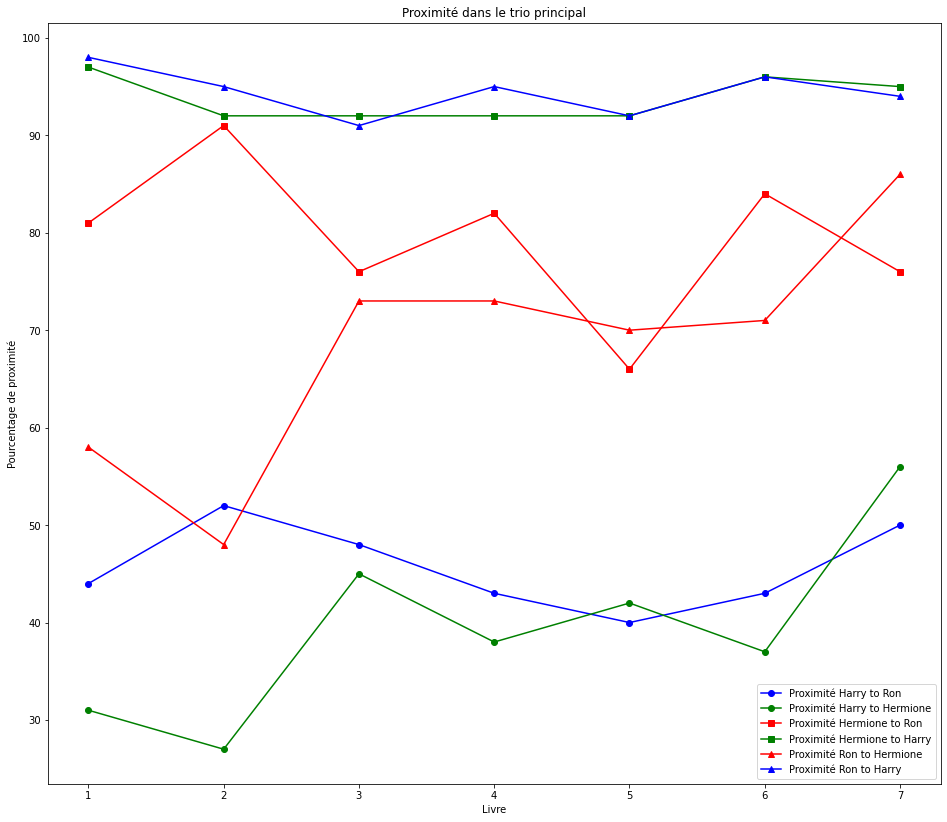

In [201]:
#Graphique
x = np.linspace(1,7,7)
plt.figure(figsize=(16,14))
plt.plot(x, harry2ron, marker = 'o', color = 'b', label = 'Proximité Harry to Ron')
plt.plot(x, harry2hermione, marker = 'o', color = 'g', label = 'Proximité Harry to Hermione')
plt.plot(x, hermione2ron, marker = 's', color = 'r', label = 'Proximité Hermione to Ron')
plt.plot(x, hermione2harry, marker = 's', color = 'g', label = 'Proximité Hermione to Harry')
plt.plot(x, ron2hermione, marker = '^', color = 'r', label = 'Proximité Ron to Hermione')
plt.plot(x, ron2harry, marker = '^', color = 'b', label = 'Proximité Ron to Harry')
plt.legend(loc = 'best', prop = {'size': 10})
plt.title('Proximité dans le trio principal')
plt.xlabel('Livre')
plt.ylabel('Pourcentage de proximité')
plt.show()

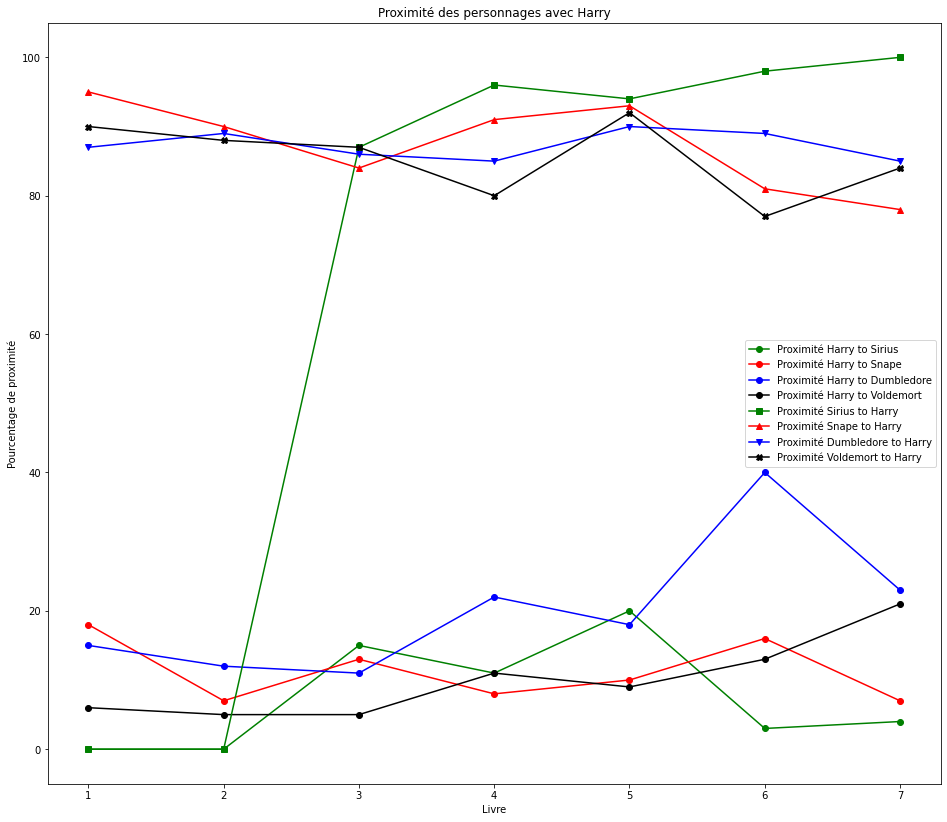

In [202]:
#Graphique
x = np.linspace(1,7,7)
plt.figure(figsize=(16,14))
plt.plot(x, harry2sirius, marker = 'o', color = 'g', label = 'Proximité Harry to Sirius')
plt.plot(x, harry2snape, marker = 'o', color = 'r', label = 'Proximité Harry to Snape')
plt.plot(x, harry2dumbledore, marker = 'o', color = 'b', label = 'Proximité Harry to Dumbledore')
plt.plot(x, harry2voldemort, marker = 'o', color = 'black', label = 'Proximité Harry to Voldemort')
plt.plot(x, sirius2harry, marker = 's', color = 'g', label = 'Proximité Sirius to Harry')
plt.plot(x, snape2harry, marker = '^', color = 'r', label = 'Proximité Snape to Harry')
plt.plot(x, dumbledore2harry, marker = 'v', color = 'b', label = 'Proximité Dumbledore to Harry')
plt.plot(x, voldemort2harry, marker = 'X', color = 'black', label = 'Proximité Voldemort to Harry')
plt.legend(loc = 'best', prop = {'size': 10})
plt.title('Proximité des personnages avec Harry')
plt.xlabel('Livre')
plt.ylabel('Pourcentage de proximité')
plt.show()

In [203]:
occ_list = [len(harry_occ[0]), len(ron_occ[0]), len(hermione_occ[0]), len(snape_occ[0]), len(dumbledore_occ[0]), len(voldemort_occ[0])]
a = 12
liens_list = [int(harry2ron[0]/a), int(harry2hermione[0]/a), int(ron2harry[0]/a), int(ron2hermione[0]/a), int(hermione2harry[0]/a), int(hermione2ron[0]/a),
             int(harry2snape[0]/a), int(harry2dumbledore[0]/a), int(harry2voldemort[0]/a),
             int(snape2harry[0]/a), int(dumbledore2harry[0]/a), int(voldemort2harry[0]/a)]

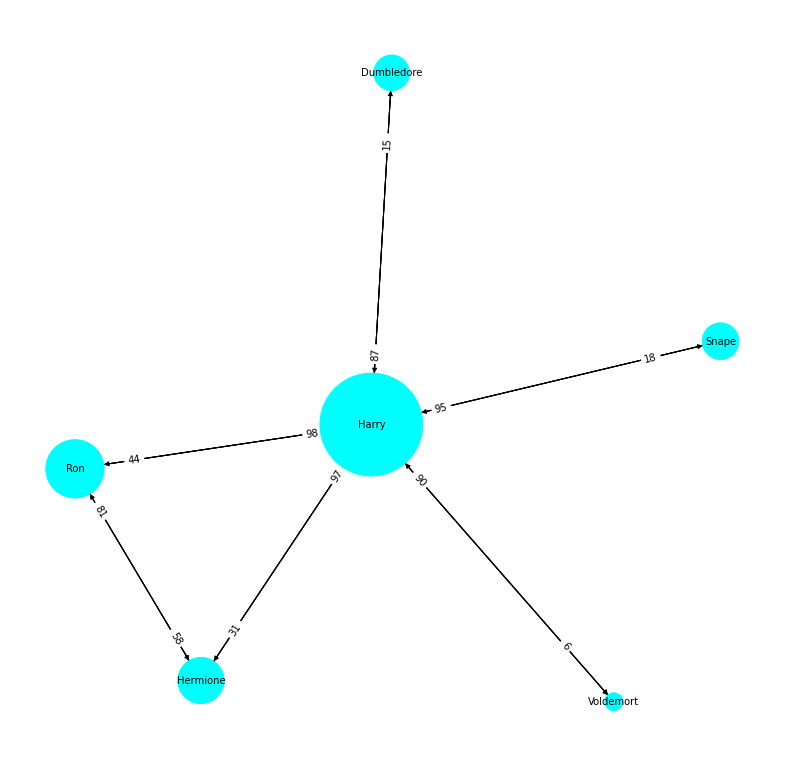

In [149]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab

plt.figure(1,figsize=(14,14))
G = nx.MultiDiGraph()

G.add_edge("Harry", "Ron", weight= int(harry2ron[0]))
G.add_edge("Harry", "Hermione", weight= int(harry2hermione[0]))
G.add_edge("Ron", "Hermione", weight= int(ron2hermione[0]))
G.add_edge("Ron", "Harry", weight= int(ron2harry[0]))
G.add_edge("Hermione", "Ron", weight= int(hermione2ron[0]))
G.add_edge("Hermione", "Harry", weight= int(hermione2harry[0]))
G.add_edge("Harry", "Snape", weight= int(harry2snape[0]))
G.add_edge("Harry", "Dumbledore", weight= int(harry2dumbledore[0]))
G.add_edge("Harry", "Voldemort", weight= int(harry2voldemort[0]))
G.add_edge("Snape", "Harry", weight= int(snape2harry[0]))
G.add_edge("Dumbledore", "Harry", weight= int(dumbledore2harry[0]))
G.add_edge("Voldemort", "Harry", weight= int(voldemort2harry[0]))

n = 8
pos=nx.spring_layout(G)
node_sizes = [n*i for i in occ_list]

edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
nx.draw_networkx_edges(G, pos, arrows = True )
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, label_pos = 0.2)
nx.draw(G,pos, node_color = 'cyan', node_size = node_sizes, edge_color = 'black')
nx.draw_networkx_labels(G, pos, font_size=10)

plt.show()

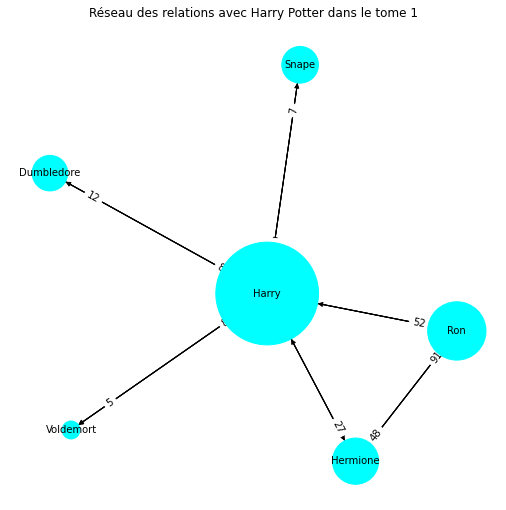

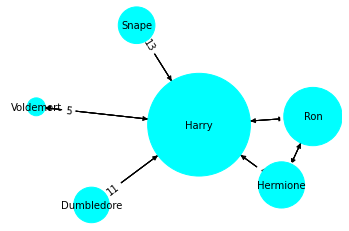

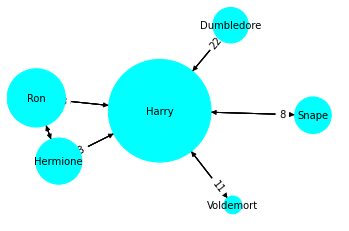

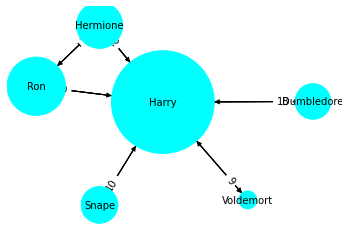

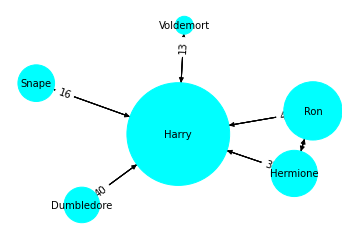

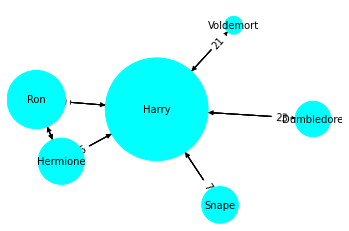

In [217]:

f = plt.figure(1, figsize =(30,30))
for i in range(1,7):
    f.add_subplot(3,3,i, title = 'Réseau des relations avec Harry Potter dans le tome %i' %i)
    G = nx.MultiDiGraph()

    G.add_edge("Harry", "Ron", weight= int(harry2ron[i]))
    G.add_edge("Harry", "Hermione", weight= int(harry2hermione[i]))
    G.add_edge("Ron", "Hermione", weight= int(ron2hermione[i]))
    G.add_edge("Ron", "Harry", weight= int(ron2harry[i]))
    G.add_edge("Hermione", "Ron", weight= int(hermione2ron[i]))
    G.add_edge("Hermione", "Harry", weight= int(hermione2harry[i]))
    G.add_edge("Harry", "Snape", weight= int(harry2snape[i]))
    G.add_edge("Harry", "Dumbledore", weight= int(harry2dumbledore[i]))
    G.add_edge("Harry", "Voldemort", weight= int(harry2voldemort[i]))
    G.add_edge("Snape", "Harry", weight= int(snape2harry[i]))
    G.add_edge("Dumbledore", "Harry", weight= int(dumbledore2harry[i]))
    G.add_edge("Voldemort", "Harry", weight= int(voldemort2harry[i]))

    n = 8
    pos=nx.spring_layout(G)
    node_sizes = [n*i for i in occ_list]

    edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edges(G, pos, arrows = True )
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, label_pos = 0.2)
    nx.draw(G,pos, node_color = 'cyan', node_size = node_sizes, edge_color = 'black')
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.show()
#bon c'est moche mais ya de l'idée

In [218]:
#tentative de fonctions mais c'est pas encore ça
def reseau_perso(persos):
    
    f = plt.figure(1,figsize=(14,14))
    
    for i in range(1,7):
        f.add_subplot(4,2,i)
        G = nx.MultiDiGraph()
        node_sizes = []
        n = 8
        
        for perso_depart in persos:
            for perso_arrivee in persos:
                if perso_depart != perso_arrivee:
                    G.add_edge(perso_depart[1], perso_arrivee[1], wieght = relation(occurence(all_text_clean_list, perso_depart), occurence(all_text_clean_list, perso_arrivee)[i]))
                    
                    pos=nx.spring_layout(G)
                    node_sizes.append(n*occurence(perso_cible)[i])
                    edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
                    
                    nx.draw_networkx_edges(G, pos, arrows = True )
                    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, label_pos = 0.2)
                    nx.draw(G,pos, node_color = 'cyan', node_size = node_sizes, edge_color = 'black')
                    nx.draw_networkx_labels(G, pos, font_size=10)
                    
    plt.show()
    return f

TypeError: 'int' object is not iterable

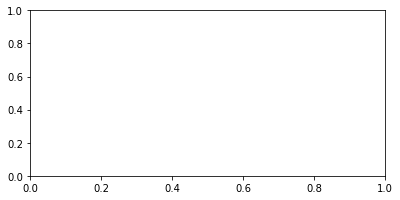

In [219]:
persos = [harry, ron, hermione, sirius, hagrid, voldemort, snape, dumbledore]
reseau_perso(persos)